# SPYxFAMILYで学ぶneo4j

https://www.youtube.com/watch?v=uRXH_LlgEWw

## 知識グラフの構成要素の説明


| 概念                        | 説明                             | 例                                   |
| ------------------------- | ------------------------------ | ----------------------------------- |
| **ノード (Node)**            | エンティティを表す（人・製品・会社など）           | `(p:Person)`                        |
| **リレーション (Relationship)** | ノード同士のつながりを表す。向きがある。           | `(:Person)-[:WORKS_AT]->(:Company)` |
| **ラベル (Label)**           | ノードの分類（型）を示すタグ。1つのノードに複数付けられる。 | `:Person`, `:Employee`, `:Manager`  |
| **プロパティ (Property)**      | ノードまたはリレーションが持つ情報（属性）          | `{name: "Alice", age: 30}`          |
| **変数 (Variable)**         | ノードやリレーションをクエリで参照するための一時的な名前   | `MATCH (p:Person) RETURN p.name`    |
| **型 (Type)**              | リレーションに付ける名前（リレーションの種類）        | `[:FRIEND_OF]`, `[:WORKS_AT]`       |

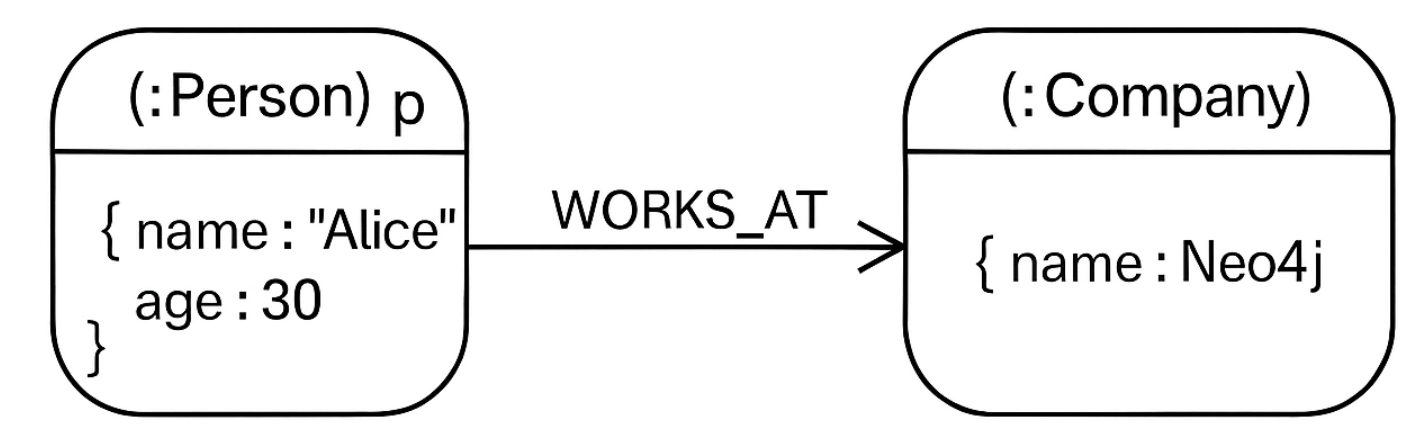



## 事前準備

### DBへの接続確認

In [1]:
from neo4j import GraphDatabase
uri = "bolt://localhost:7689"
user = "neo4j"          # ユーザー名
password = "password"   # データベース作成時に設定したパスワード
driver = GraphDatabase.driver(uri, auth=(user, password))

### すべてのデータのクリーンナップ

In [2]:
def delete_all_data(tx):
    tx.run("MATCH (n) DETACH DELETE n")

with driver.session() as session:
    all_nodes = session.execute_write(delete_all_data)

print(all_nodes)

None


## STEP1: フォージャー家のノードを作成

In [15]:
# クエリの実行
def create_family_nodes(tx):
    tx.run(
        """
        CREATE (:Person {name: 'ロイド'})
        CREATE (:Person {name: 'ヨル'})
        CREATE (:Person {name: 'アーニャ'})
        CREATE (:Dog {name: 'ボンド'})
        """
    )

# セッションの開始とクエリの実行
with driver.session() as session:
    family_nodes = session.execute_write(create_family_nodes)

ノードは、ラベルとプロパティによって特徴づけられます。
ご提示のクエリ `(p1:Person {name: 'ロイド'})` においては、

* `Person` というラベルが付けられたノードがあり、
* そのノードが `name` というプロパティを持っており、
* その `name` プロパティの値が `'ロイド'` である

ということを示しています。

ラベル、プロパティーは複数与えることもできます。

```python
CREATE (p1:Person:Spy:Father {name: 'ロイド', age: 30, occupation: 'スパイ'})
```

In [16]:
# ノードを取得するクエリ関数
def get_family_nodes(tx):
    result = tx.run(
        """
        MATCH (n)
        WHERE n.name IN ['ロイド', 'ヨル', 'アーニャ', 'ボンド']
        RETURN labels(n) AS labels, n.name AS name
        """
    )
    return [{"labels": record["labels"], "name": record["name"]} for record in result]

# セッション内でクエリを実行し、結果を表示
with driver.session() as session:
    family_nodes = session.execute_read(get_family_nodes)
    for node in family_nodes:
        print(f"ノードのラベル: {node['labels']}, 名前: {node['name']}")

ノードのラベル: ['Person'], 名前: ロイド
ノードのラベル: ['Person'], 名前: ヨル
ノードのラベル: ['Person'], 名前: アーニャ
ノードのラベル: ['Dog'], 名前: ボンド


![img1](./SPYxFAMILY_step1.png)

## STEP2: フォージャー家のrelationを作成

### relationの作成

In [5]:
# クエリの実行
def create_family_relations(tx):
    tx.run("""
        MATCH (p1:Person {name: 'ロイド'}),
              (p2:Person {name: 'ヨル'}),
              (p3:Person {name: 'アーニャ'})
        CREATE (p1)-[:FATHER]->(p3)
        CREATE (p2)-[:MOTHER]->(p3)
        CREATE (p1)-[:MARRIED]->(p2)
    """)

# セッションの開始とクエリの実行
with driver.session() as session:
    family_relations = session.execute_write(create_family_relations)

Neo4jのCypherクエリにおいて、p1のようなものは変数 (variable) と呼びます

- この文脈では、p1 は MATCH句で見つかった Person ラベルを持ち name プロパティが 'ロイド' であるノードを指す変数です
- 具体的には、p1、p2、p3 はそれぞれ特定のノードを指すノード変数 (node variable) です
- 同様に、リレーションシップを変数に束縛することも可能で、その場合はリレーションシップ変数 (relationship variable) と呼ばれます
- このクエリでは、p1、p2、p3 という変数を使って、それぞれのノードを識別し、それらの間に新しいリレーションシップ (FATHER, MOTHER, MARRIED) を作成しています

### 作成したrelationの確認

In [6]:
# リレーションシップを取得する関数
def get_family_relations(tx):
    result = tx.run("""
        MATCH (p1:Person)-[r]->(p2)
        WHERE p1.name IN ['ロイド', 'ヨル', 'アーニャ'] AND p2.name IN ['ロイド', 'ヨル', 'アーニャ']
        RETURN p1.name AS from, type(r) AS relation, p2.name AS to
    """)
    return [{"from": record["from"], "relation": record["relation"], "to": record["to"]} for record in result]

# セッションの開始とクエリの実行
with driver.session() as session:
    # リレーションシップの取得と表示
    relations = session.execute_read(get_family_relations)
    for rel in relations:
        print(f"{rel['from']} -[{rel['relation']}]-> {rel['to']}")

ロイド -[FATHER]-> アーニャ
ヨル -[MOTHER]-> アーニャ
ロイド -[MARRIED]-> ヨル


![](./SPYxFAMILY_step2.png)

## STEP3: フォージャーFAMILYの明示

In [7]:
# クエリの実行
def create_family_group(tx):
    # - family: ノード変数
    # - Family: ラベル
    # - {name: 'フォージャー'}: プロパティのキーと値
    tx.run("CREATE (family:Family {name: 'フォージャー'}) "
           "WITH family " 				# WITH句でfamilyを次のクエリに渡す
           "MATCH (person:Person) "		# Personを取得し変数personに格納
           "CREATE (family)-[:FAMILY]->(person) ") # familyとpersonをFAMILYリレーションシップで接続

# セッションの開始とクエリの実行
with driver.session() as session:
    session.execute_write(create_family_group)

In [8]:
# def count_family_relationships(tx):
#     result = tx.run("""
#         MATCH (p1:Family)-[r]->(p2)
#         WHERE p1.name IN ['Family'] AND p2.name IN ['ロイド', 'ヨル', 'アーニャ']
#         RETURN p1.name AS from, type(r) AS relation, p2.name AS to
#     """)
#     return [{"from": record["from"], "relation": record["relation"], "to": record["to"]} for record in result]

# with driver.session() as session:
#     res = session.execute_read(count_family_relationships)
#     print(f"FAMILYリレーション: {res}")

In [9]:
# # リレーションシップを取得する関数
# def get_family_group(tx):
#     result = tx.run("""
#         MATCH (family:Family)-[r]->(person:Person)
#         WHERE person.name IN ['Person']
#         RETURN family.name AS from, type(r) AS relation, n.name AS to
#     """)
#     return [{"from": record["from"], "relation": record["relation"], "to": record["to"]} for record in result]

# # セッションの開始とクエリの実行
# with driver.session() as session:
#     # リレーションシップの取得と表示
#     relations = session.execute_read(get_family_group)
#     print(relations)
#     for rel in relations:
#         print(f"{rel['from']} -[{rel['relation']}]-> {rel['to']}")

![](./SPYxFAMILY_step3.png)

## STEP4: ボンド(犬)もフォージャーFAMILYだ!

In [10]:
# クエリの実行
def create_family_group_with_dog(tx):
    tx.run("MATCH (dog:Dog) "
           "MATCH (family:Family) "
           "CREATE (family)-[:FAMILY]->(dog) ")

# セッションの開始とクエリの実行
with driver.session() as session:
    session.execute_write(create_family_group_with_dog)

![](./SPYxFAMILY_step4.png)

## STEP5: アーニャのageプロパティ (7歳)を加える

In [11]:
# クエリの実行
def add_anya_age(tx):
    # アーニャの年齢を7に設定
    # MATCH句でアーニャのノードを取得し、SET句でプロパティを更新
    tx.run("MATCH (p3:Person {name: 'アーニャ'}) "
           "SET p3.age = 7")

# セッションの開始とクエリの実行
with driver.session() as session:
    session.execute_write(add_anya_age)

In [12]:
def get_anya_age(tx):
    result = tx.run("MATCH (p:Person {name: 'アーニャ'}) "
                    "RETURN p.age AS age")
    record = result.single()
    return record["age"] if record else None

with driver.session() as session:
    anya_age = session.execute_read(get_anya_age)
    print(f"アーニャの年齢は {anya_age} 歳です。")

アーニャの年齢は 7 歳です。


# 全データの削除

In [13]:
def delete_all_data(tx):
    tx.run("MATCH (n) DETACH DELETE n")

with driver.session() as session:
    all_nodes = session.execute_write(delete_all_data)

print(all_nodes)

None
